# Let's Train SmolLM 135M



### Configure the machine and install packages


In [1]:
import os

#os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

from typing import Literal

import jax

platform : Literal["darwin", "colab", "cuda"] = "darwin"

try:
    import google.colab
    platform = "colab"
except ImportError:
    devices = jax.devices()
    if any(d.platform == "gpu" for d in devices):
        platform = "cuda"

print(f"Running on {platform}")

if platform == "colab":
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout main && git pull
    !pip install tiktoken datasets --quiet
    !pip uninstall -y tensorflow

Running on colab
Cloning into 'jaxpt'...
remote: Enumerating objects: 2318, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 2318 (delta 129), reused 80 (delta 74), pack-reused 2140 (from 2)
Receiving objects: 100% (2318/2318), 330.35 MiB | 46.51 MiB/s, done.
Resolving deltas: 100% (1416/1416), done.
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


In [2]:
from pathlib import Path
import sys

if platform == "colab":
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )


sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/content/jaxpt/src


In [3]:
import os
import warnings

import jax
import flax
import jax.numpy as jnp
import numpy as np

from jax.sharding import Mesh, PartitionSpec, NamedSharding

# Hardware setup
print("JAX version:", jax.__version__)
print("Flax version", flax.__version__)
devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

requested_device = "gpu"

jax.config.update("jax_platform_name", requested_device) # Make sure we're using the GPU

mesh = Mesh(devices, ("devices",))
spec = PartitionSpec("devices",)
sharding = NamedSharding(mesh, spec)

device = jax.default_backend()
if device != requested_device:
    warnings.warn(f"not using {requested_device}. Using {device}")
else:
    print(f"using {device}")


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################

jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
#os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

if device == "tpu":
    def list_tpu_memory():
        devices = jax.devices()
        for device in devices:
            if 'TPU' in str(device.device_kind):
                print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

    list_tpu_memory()

# Test the device
A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Make sure matmul is fast
%timeit (A@A).block_until_ready()

JAX version: 0.5.2
Flax version 0.10.6
Available devices: 1
using gpu
818 µs ± 27.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Initialize SmolLLM model and perform a sanity check

In [4]:
from flax import nnx

from jaxpt.infer import generate_completions, generate
from jaxpt.models import SmolLM, SmolLM_Config
from jaxpt.models.smol_lm import from_hf_pretrained
from jaxpt.utils import count_params, create_sharded_model

from transformers import AutoTokenizer

key = jax.random.PRNGKey(1337)
rngs = nnx.Rngs(key)
config = SmolLM_Config(dtype=jnp.bfloat16, \
                    #vocab_size=49152,
                    block_size=2048,
                    n_embed=576,
                    n_mlp_hidden=1536,
                    n_head=9,
                    n_kv_head=3,
                    use_cache=False,
                    mesh=mesh,
                    sdpa_implementation="cudnn" if device=="gpu" else "xla")
nnx.display(config)
with mesh:
    m = create_sharded_model(SmolLM, config, rngs)
    #m = SmolLM(config, rngs)
    #graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
    #nnx.display(state)
    #m = load_checkpoint("run_20250311_uqdwjq", 5600)
    #m = from_hf_pretrained(config, rngs)

    graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
    total_params = count_params(m)

    print(f"Parameter Count: {total_params:,}")
    nnx.display(state)

    tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")
    #completions = generate_completions(m, enc=tokenizer, num_completions=5, max_length=21, prefix="Ducks quack, donkeys bray, cats mew, horses")
    #for completion in completions:
    #    print(completion)

Parameter Count: 135,151,488


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

In [5]:
jax.debug.visualize_array_sharding(state.rms_n_f.scale.value)

  GPU 0  
         

### Configure Training Run

In [6]:
from datetime import datetime
import random
import string


def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_random_code()

run_dirname = f"run_{timestamp}_{random_code}"
print(f"Run: {run_dirname}")

if platform == "colab":
  output_dir = Path().absolute().parent
elif platform == "cuda":
  output_dir = Path("/home/ubuntu/gpt2-train") # Lambda Labs setup
else:
  output_dir = Path().absolute().parent # Local setup

# Create checkpoint dir
checkpoint_dir = output_dir / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Checkpoint directory: {checkpoint_dir}")

# Create log dir
log_dir = output_dir / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
print(f"Log directory: {log_dir}")

def save_checkpoint(m, run_dirname, step):
  checkpoint_path = checkpoint_dir / run_dirname / f"checkpoint-{step}.pt"
  m.save_checkpoint(checkpoint_path)

def load_checkpoint(model, run_dirname, step):
  checkpoint_path = checkpoint_dir / run_dirname / f"checkpoint-{step}.pt"
  m = model.load_checkpoint(checkpoint_path, rngs)
  return m

Run: run_20250721_uyvyru
Checkpoint directory: /checkpoints
Log directory: /logs


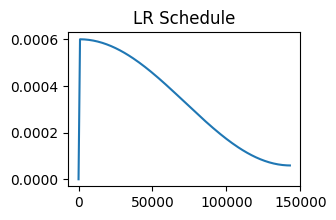

weight decay param count: 135,116,352
tokens/batch: 2,048
block size: 128
batch size: 16
no. gradient accumulation steps: 1
effective batch size: 16
effective batch size per device:  16
max steps: 143,335


In [7]:
import dataclasses

import optax


############################
# Nvidia A100 (x 8) Config #
############################

@dataclasses.dataclass
class TrainerConfig:
  num_tokens_per_batch: int = 2**11 # 2**19, 0.5 million as per the GPT 3.5 paper
  mB: int = 16 * num_devices
  T: int = 128
  max_steps: int = int((2000*146776) // (2**11))
  max_lr: float = 6e-4
  min_lr: float = max_lr * 0.1
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 715
  print_interval: int = 1
  eval_interval: int = 1
  checkpoint_interval: int = 10000
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T) # Number of steps over which to average the gradient


##############
# CPU Config #
##############

trconf = TrainerConfig()
'''
trconf = TrainerConfig(
  num_tokens_per_batch=2**9,
  mB=2**4,
  T=2**5,
  max_steps=9*48, # 6 epoch(s)
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=1,
  eval_interval=50,
  checkpoint_interval=0,

)

trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient
'''

# Set up the optimizer
cool_down_period = 0.3
def trapezoidal_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    cooldown_lr = trconf.max_lr * (trconf.max_steps - step) / (trconf.max_steps - (1 - cool_down_period) * trconf.max_steps)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < (1 - cool_down_period) * trconf.max_steps, trconf.max_lr, cooldown_lr))

def warmup_with_cosine_decay_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    coeff = 0.5 * (1 + jnp.cos(jnp.pi * (step - trconf.warmup_steps) / (trconf.max_steps - trconf.warmup_steps)))
    cosine_lr =  trconf.min_lr + coeff * (trconf.max_lr - trconf.min_lr)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < trconf.max_steps, cosine_lr, trconf.min_lr))

steps = range(0, trconf.max_steps, 1000)
total_schedule = [ warmup_with_cosine_decay_schedule(step) for step in steps ]
import matplotlib.pyplot as plt
plt.figure(figsize=(3,2))
plt.plot(steps, total_schedule)
plt.title("LR Schedule")
plt.show()

# Generate a weight decay mask
# First split the model into params and variables
graphdef, params, variables = nnx.split(m, nnx.Param, nnx.Variable)
# Then create a mask for the weight decay params
weight_decay_mask = jax.tree_util.tree_map(lambda x: len(x.shape) > 1, params)

tx = optax.chain(
    #optax.clip_by_global_norm(trconf.max_grad_norm),
    optax.adamw(warmup_with_cosine_decay_schedule, b1=0.9, b2=0.95, weight_decay=0.1) # mask=weight_decay_mask),
    #optax.adafactor(trapezoidal_schedule)
)
optimizer = nnx.Optimizer(m, tx)

# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 0

weight_decay_params = jax.tree_util.tree_map(f, weight_decay_mask, params)
weight_decay_param_count = jax.tree_util.tree_reduce(lambda x, y: x + y, weight_decay_params, 0)


print(f"weight decay param count: {weight_decay_param_count:,}")
print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB // num_devices)
print(f"max steps: {trconf.max_steps:,}")


### DataLoader and Validation Setup



In [8]:
from jaxpt.dataloaders import DataLoader, HuggingfaceDataLoader, CloudDataLoader

batch_size = trconf.T * trconf.mB * trconf.grad_accumulation_steps
batch_memory = batch_size*2
print(f"Batch Size (Tokens): {batch_size:,} | Batch Memory: {batch_memory/1024} MB")

'''
train_dl = HuggingfaceDataLoader(batch_size=trconf.mB * DATA_DIMS,
                                 block_size=trconf.T,
                                 device_rank=1,
                                 tokenizer="HuggingFaceTB/SmolLM-135M",
                                 dataset_paths=["HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus"],
                                 dataset_names=["cosmopedia-v2",
                                                "python-edu",
                                                "fineweb-edu-dedup"],
                                 probabilities=[0.111, 0.016 , 0.873],
                                 label="train",
                                 random_seed=1337,
                                 buffer_size=10_000,
                                 streaming=True)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./alpha-448101-282bc1b884cd.json"

train_dl = CloudDataLoader(bucket_name="jaxpt_datasets",
                      bucket_prefix="fineweb-edu-100b/processed",
                      batch_size=trconf.mB,
                      block_size=trconf.T,
                      device_rank=1,
                      label="train")

'''
train_dl = DataLoader(dirpath="/content/jaxpt/datasets/panchatantra-ryder/processed",
                      batch_size=trconf.mB,
                      block_size=trconf.T,
                      device_rank=1,
                      label="train")



Batch Size (Tokens): 2,048 | Batch Memory: 4.0 MB
DataLoader initialized:
------------------------
label:          train
shards:         1
shard size:     146,776
batch size:     16
block size:     128
device rank:    1
------------------------


In [9]:
from jaxpt.utils import append_to_csv

train_losses = []
append_to_csv(log_dir / f"{run_dirname}_train.csv", ["step", "lr", "loss", "time", "tokens_processed", "tokens_per_sec"])
step = 0

Streaming output truncated to the last 5000 lines.
Evaluation TBD
519 | lr: 4.36e-04 | loss: 3.9213 | time: 57.91ms | tokens processed: 1,064,960 | tok/sec: 35,363.79
Evaluation TBD
520 | lr: 4.37e-04 | loss: 3.6589 | time: 57.78ms | tokens processed: 1,067,008 | tok/sec: 35,442.73
Evaluation TBD
521 | lr: 4.38e-04 | loss: 3.7967 | time: 60.27ms | tokens processed: 1,069,056 | tok/sec: 33,983.07
Evaluation TBD
522 | lr: 4.39e-04 | loss: 3.6584 | time: 61.64ms | tokens processed: 1,071,104 | tok/sec: 33,223.88
Evaluation TBD
523 | lr: 4.40e-04 | loss: 3.6217 | time: 61.21ms | tokens processed: 1,073,152 | tok/sec: 33,459.80
Evaluation TBD
524 | lr: 4.41e-04 | loss: 3.6697 | time: 61.55ms | tokens processed: 1,075,200 | tok/sec: 33,276.13
Evaluation TBD
525 | lr: 4.41e-04 | loss: 3.6401 | time: 62.36ms | tokens processed: 1,077,248 | tok/sec: 32,839.78
Evaluation TBD
526 | lr: 4.42e-04 | loss: 3.4598 | time: 59.07ms | tokens processed: 1,079,296 | tok/sec: 34,669.55
Evaluation TBD
527 | 

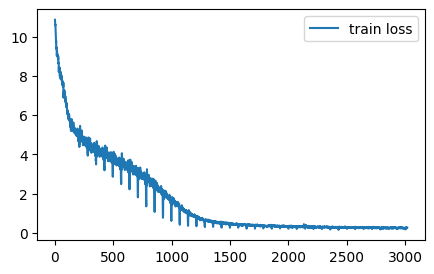

In [10]:
%matplotlib inline

import time

import matplotlib.pyplot as plt


def loss_fn(model, batch, targets):
    logits = model(batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, targets)
    return loss.mean(), logits


@nnx.jit
def train_step(model, optimizer, batch, targets):
    (loss, logits), grads = nnx.value_and_grad(loss_fn, has_aux=True)(model, batch, targets)
    optimizer.update(grads)
    return loss, grads, logits


m.train()
try:
  while step < trconf.max_steps:
    start = time.time()
    batch, target = train_dl()
    batch = jax.device_put(batch.squeeze(), sharding)
    target = jax.device_put(target.squeeze(), sharding)
    loss, grads, logits = train_step(m, optimizer, batch, target)

    if step % trconf.print_interval == 0:
      # compute stats
      loss.block_until_ready()
      lr = warmup_with_cosine_decay_schedule(step)
      iter_time = time.time() - start
      sub_step_time = iter_time / trconf.grad_accumulation_steps
      tokens_per_sec = trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time
      tokens_processed = (step+1) * trconf.grad_accumulation_steps * trconf.mB * trconf.T

      train_losses.append((step, loss))
      append_to_csv(log_dir / f"{run_dirname}_train.csv", [step, lr, loss, iter_time*1000, tokens_processed, tokens_per_sec])
      print(f"{step} | lr: {lr:0.2e} | "
            f"loss: {loss:0.4f} | "
            f"time: {iter_time*1000:0.2f}ms | "
            f"tokens processed: {tokens_processed:,} | "
            f"tok/sec: {tokens_per_sec:,.2f}")#, end="\r")
    if step % trconf.eval_interval == 0:
      print("Evaluation TBD")
      #save_checkpoint(m, run_dirname, step)
    step += 1

except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")

plt.figure(figsize=(5, 3))
plt.plot([x[0] for x in train_losses], [x[1] for x in train_losses], label="train loss")
plt.legend()
plt.savefig(log_dir / f"{run_dirname}.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()


In [ ]:
completions = generate_completions(m, enc=tokenizer, max_length=40)
for completion in completions:
    print(completion)